In [1]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
import skimage.io as io

### Read Dataset

In [2]:
def read_images(folder_path):
   '''
    Read images from a folder and return them as a list of numpy arrays.
    Normalize the images
   '''
   images = []
   file_names = os.listdir(folder_path)
   for file_name in file_names:
         image = io.imread(os.path.join(folder_path, file_name))
         images.append(image)
   
   return images
 
# read dataset 
A = read_images('dataset/trainval/A') # initial images
B = read_images('dataset/trainval/B') # images after a certain amount of time
labels = read_images('dataset/trainval/label') # ground truth images (actual change)

assert len(A) == len(B) == len(labels), "Number of images in A, B and labels are not equal."

In [3]:
# Split dataset into training, validation and test sets
A_train, A_test, B_train, B_test, labels_train, labels_test = train_test_split(A, B, labels, test_size=0.3, random_state=42)

# we can use the same function to split the training set into training and validation sets
# A_train, A_val, B_train, B_val, labels_train, labels_val = train_test_split(A_train, B_train, labels_train, test_size=0.2, random_state=42)

## Research findings: <br>
1. I think the most appropriate approach given the dataset is ab Object-Based Chnage Detection (By adopting an object-based approach, you can achieve more accurate and meaningful results for change detection in complex landscapes such as desert areas, where pixel-based methods may be less effective due to spatial heterogeneity and spectral variability.) and since our dataset is detecting change in desert areas, specifically buildings.
2. For image prerpcessing: first step is to apply radiometric normalization to remove the atmospheric effect and any noise 


Random image before change


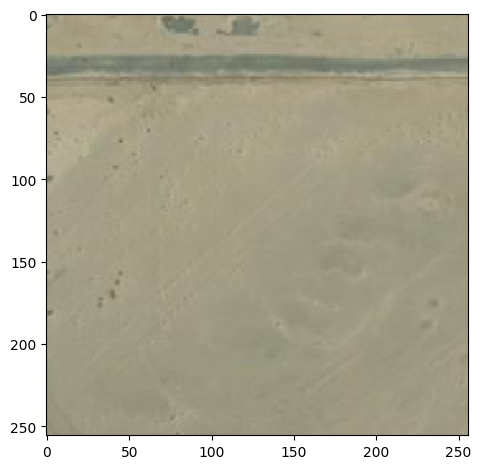

Random image after change


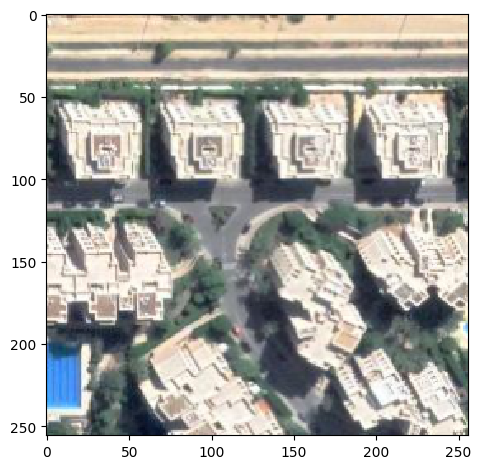

Change ground truth of the random image


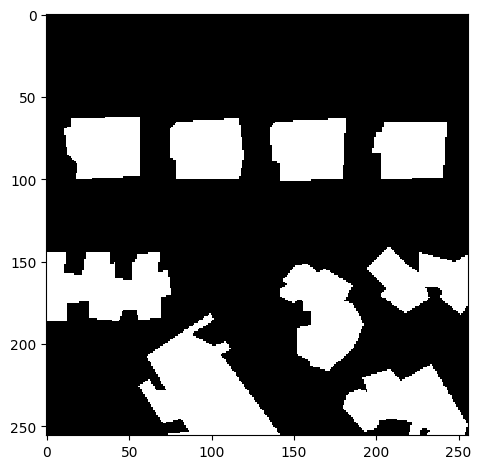

In [20]:
# Show first image in the training set
random_index = np.random.randint(0, len(A_train))

print("Random image before change")
io.imshow(A_train[random_index])
io.show()

print("Random image after change")
io.imshow(B_train[random_index])
io.show()

print("Change ground truth of the random image")
io.imshow(labels_train[random_index])
io.show()

### Image Preprocessing


In [5]:
# For image preprocessing there are 3 main steps to try:
# 1. Radiometric correction
# 2. Geometric correction
# 3. Image enhancement
'''
There are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:
1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. 
2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. 
3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. 
4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.
'''

'\nThere are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:\n1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. \n2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. \n3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. \n4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.\n'

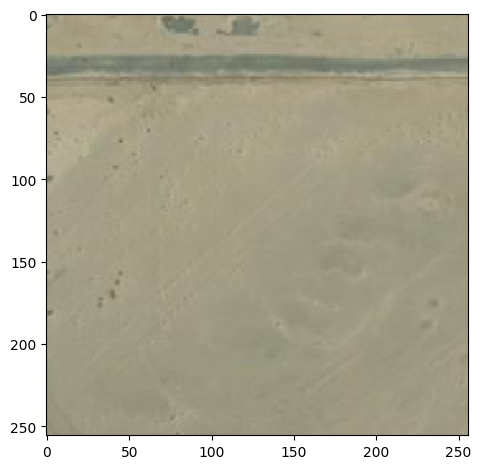

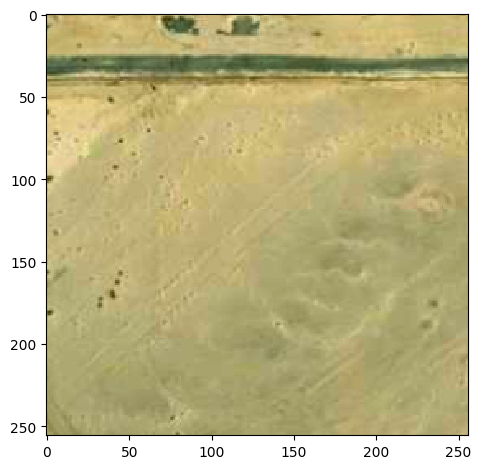

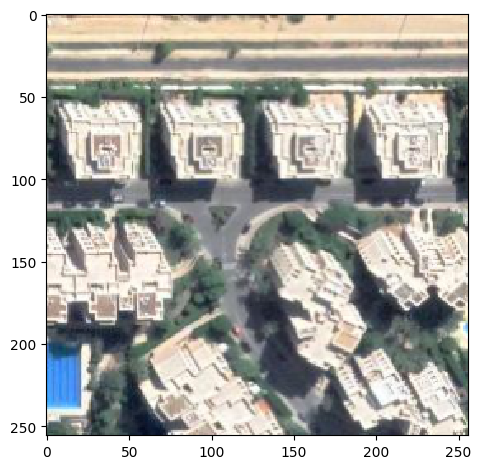

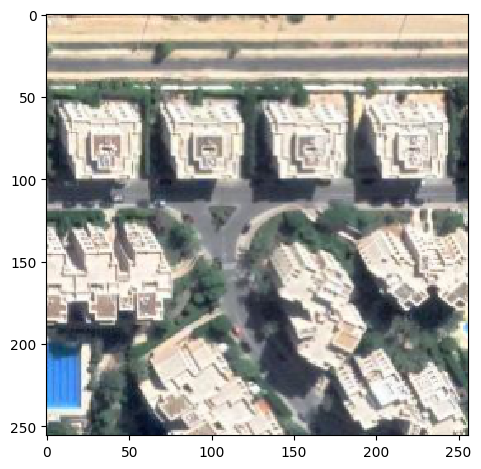

In [21]:
# Applying radiometric correction on a single image before and after

# Convert to floating point for radiometric correction
image_float_A = A_train[random_index].astype(np.float32)
image_float_B = B_train[random_index].astype(np.float32)

# Radiometric correction (e.g., flat field correction, atmospheric correction)
# Example: Subtract mean and divide by standard deviation
mean = np.mean(image_float_A)
std_dev = np.std(image_float_A)
corrected_image = (image_float_A - mean) / std_dev

# Normalize the corrected image to [0, 255]
normalized_image_A = cv2.normalize(corrected_image, None, 0, 255, cv2.NORM_MINMAX)
normalized_image_B = cv2.normalize(image_float_B, None, 0, 255, cv2.NORM_MINMAX)

# Convert back to uint8 format
normalized_image_A = np.uint8(normalized_image_A)
normalized_image_B = np.uint8(normalized_image_B)

# Display the original and normalized images
io.imshow(A_train[random_index])
io.show()
io.imshow(normalized_image_A)
io.show()

io.imshow(B_train[random_index])
io.show()
io.imshow(normalized_image_B)
io.show()

### Classical Technique:
#### Image Differencing

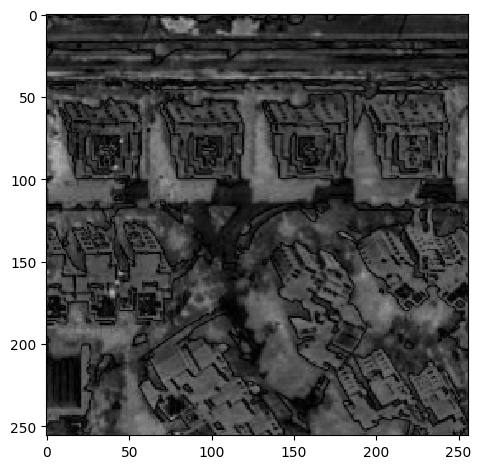

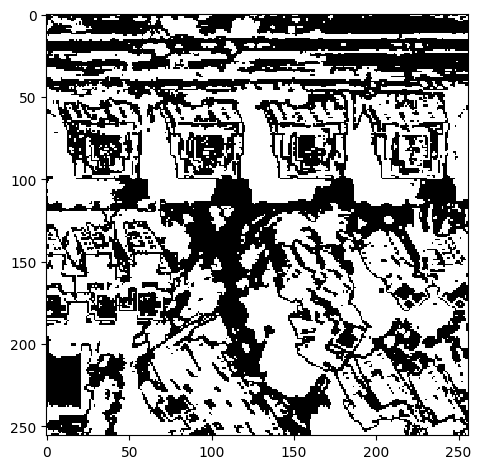

In [30]:
# Apply image differencing to detect changes

# convert to grayscale
gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)

# Compute the absolute difference between the two images
difference_image = cv2.absdiff(gray_image_A, gray_image_B)
# show the difference image
io.imshow(difference_image)
io.show()

# apply thresholding to the difference image
threshold = 50
_, thresholded_image = cv2.threshold(difference_image, threshold, 255, cv2.THRESH_BINARY)

# show the difference image
io.imshow(thresholded_image)
io.show()

In [29]:
# convert images to grayscale
gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)

# compute the mean and variance for A and B
mean_A = np.mean(gray_image_A)
mean_B = np.mean(gray_image_B)
var_A = np.var(gray_image_A)
var_B = np.var(gray_image_B)

# print the mean and variance for A and B
print("Mean of A: ", mean_A)
print("Mean of B: ", mean_B)
print("Variance of A: ", var_A)
print("Variance of B: ", var_B)

Mean of A:  154.3072052001953
Mean of B:  153.22125244140625
Variance of A:  327.7613225968089
Variance of B:  4020.0183386169374


### Deep Learning Technique:
#### U-Net